In [1]:
#Import Libraries
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import re
import nltk
from numpy import triu
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("./flipkart_reviews_data.csv")

In [3]:
df.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [4]:
print(df.shape)

(205052, 6)


In [5]:
df['Sentiment'].value_counts()

Sentiment
positive    166581
negative     28232
neutral      10239
Name: count, dtype: int64

In [6]:
sentiment_distribution = df['Sentiment'].value_counts()

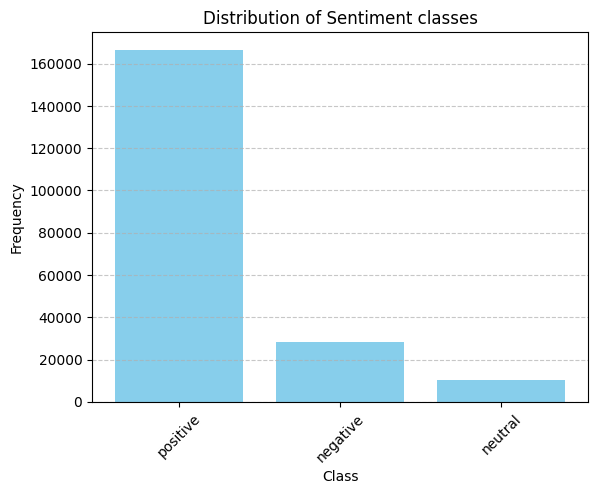

In [7]:
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color='skyblue')
plt.title('Distribution of Sentiment classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
# Resample each class to the same count to make the class balanced
min_class_count = df['Sentiment'].value_counts().min()
df_balanced= df.groupby('Sentiment').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)
print(df_balanced['Sentiment'].value_counts())

Sentiment
negative    10239
neutral     10239
positive    10239
Name: count, dtype: int64


In [9]:
df_balanced.isnull().sum()

product_name        0
product_price       0
Rate                0
Review           4024
Summary             6
Sentiment           0
dtype: int64

In [10]:
#Removing the nulls present in Summary column
df_balanced.dropna(subset=['Summary'],inplace=True, axis=0)

In [11]:
df_balanced.isnull().sum()

product_name        0
product_price       0
Rate                0
Review           4023
Summary             0
Sentiment           0
dtype: int64

In [12]:
nltk.download('stopwords')
nltk.download('punkt')


stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text=str(text)
    text = BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    words = word_tokenize(text)
    processed_words = [stemmer.stem(word) for word in words if word.isalnum() and word not in stop_words]
    processed_text = ' '.join(processed_words)
    return processed_text



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
df_balanced['summary_cleaned']=df_balanced['Summary'].apply(preprocess_text)

In [14]:
print(sorted(df_balanced['Sentiment'].unique().tolist()))

['negative', 'neutral', 'positive']


In [15]:
encoding={val:key for key,val in enumerate(sorted(df_balanced['Sentiment'].unique().tolist()))}

In [16]:
encoding

{'negative': 0, 'neutral': 1, 'positive': 2}

In [17]:
label_id=pd.DataFrame(encoding.items(),columns=['labels','classes'])

In [18]:
label_id

,labels,classes
0,negative,0
1,neutral,1
2,positive,2


In [19]:
label_id.to_csv("label_to_id.csv",index=False)

In [20]:
df_balanced['sentiment_class'] =df_balanced['Sentiment'].map(encoding)

In [21]:
df_balanced.head()

,product_name,product_price,Rate,Review,Summary,Sentiment,summary_cleaned,sentiment_class
0,Men Graphic Print Round Neck Black T-Shirt,269,1,NaN,very bed cloth,negative,bed cloth,0
1,Boys & Girls Full Sleeve Printed Sweatshirt,599,1,NaN,thats is very bad i will order beautiful colou...,negative,that bad order beauti colour print good print ...,0
2,Mayne Exceed Helicopter With Remote Control Ch...,369,1,don't waste your money,bed quality,negative,bed qualiti,0
3,Men Checkered Single Breasted Formal Blazer???...,4366,1,NaN,poor qualityi return it,negative,poor qualityi return,0
4,POOWEREST Carbon Steel Collapsible WardrobeFin...,495,1,utterly disappointed,wastage of money,negative,wastag money,0


In [22]:
# Creates TF-IDF vectorizer and transforms the corpus
vectorizer = TfidfVectorizer()
reviews_corpus = vectorizer.fit_transform(df_balanced['summary_cleaned'])
reviews_corpus.shape

(30711, 12308)

In [23]:
sentiment = df_balanced['sentiment_class']
sentiment.shape

(30711,)

In [46]:
#Split the data to training and testing set with ratio 70:30
X_train,X_test,y_train,y_test = train_test_split(reviews_corpus,sentiment,test_size=0.3,random_state=42)
print('Train data shape ',X_train.shape,y_train.shape)
print('Test data shape ',X_test.shape,y_test.shape)

Train data shape  (21497, 12308) (21497,)
Test data shape  (9214, 12308) (9214,)


In [68]:
#Use Naive Bayes, Random Forest, XGBoost to fit the training data

clf_naive_bayes = MultinomialNB().fit(X_train, y_train) #fit the training data
pred_naive_bayes = clf_naive_bayes .predict(X_test) #predict the sentiment for test data

clf_random_forest = RandomForestClassifier(n_estimators=50).fit(X_train, y_train)
pred_random_forest  = clf_random_forest.predict(X_test)


clf_xgboost = XGBClassifier(n_estimators=50,reg_alpha=0.001,\
                            reg_lambda=0.001,use_label_encoder=False,\
                            eval_metric='logloss').fit(X_train, y_train)
pred_xgboost = clf_xgboost.predict(X_test)


In [85]:
## Check the performance of the models
accuracy_naive_bayes = accuracy_score(y_test, pred_naive_bayes)
report_naive_bayes  = classification_report(y_test, pred_naive_bayes)


accuracy_random_forest  = accuracy_score(y_test, pred_random_forest)
report_random_forest  = classification_report(y_test, pred_random_forest)

accuracy_xgboost  = accuracy_score(y_test, pred_xgboost)
report_xgboost   = classification_report(y_test, pred_xgboost)


In [86]:
print(f"The accuracy of Naive Bayes Model is {accuracy_naive_bayes*100:.2f}%")
print(f"Performance Metrics of Naive Bayes Model\n")
print(report_naive_bayes)
print("*"*100)
print("\n\n")


print(f"The accuracy of Random Forest Model is {accuracy_random_forest*100:.2f}%")
print(f"Performance Metrics of Random Forest Model\n")
print(report_random_forest)
print("*"*100)
print("\n\n")



print(f"The accuracy of Xgboost Model is {accuracy_xgboost*100:.2f}%")
print(f"Performance Metrics of Xgboost Model\n")
print(report_xgboost)
print("*"*100)
print("\n\n")


The accuracy of Naive Bayes Model is 76.72%
Performance Metrics of Naive Bayes Model

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      3085
           1       0.82      0.64      0.72      3058
           2       0.79      0.86      0.82      3071

    accuracy                           0.77      9214
   macro avg       0.77      0.77      0.76      9214
weighted avg       0.77      0.77      0.76      9214

****************************************************************************************************



The accuracy of Random Forest Model is 78.19%
Performance Metrics of Random Forest Model

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      3085
           1       0.78      0.73      0.75      3058
           2       0.80      0.86      0.83      3071

    accuracy                           0.78      9214
   macro avg       0.78      0.78      0.78      9214
weighted avg 

### XGBoost gave the best Results. 

### Using Word2Vec to see if this featurization technique can improve the performance

In [ ]:

nltk.download('punkt')

In [39]:
# Preprocess text: tokenize and remove stopwords
stop_words = set(stopwords.words('english'))
def preprocess(text):
    words = word_tokenize(str(text).lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return words

df_balanced['tokens'] = df_balanced['Summary'].apply(preprocess)


In [40]:
# Train Word2Vec model
sentences = df_balanced['tokens'].tolist()
word2vec_model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4)

In [41]:
# Function to average word vectors for a text
def vectorize_text(tokens, model):
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(word_vectors) > 0:
        return sum(word_vectors) / len(word_vectors)
    else:
        return [0] * model.vector_size

In [42]:
# Apply vectorization to the dataset
df_balanced['vector'] = df_balanced['tokens'].apply(lambda tokens: vectorize_text(tokens, word2vec_model))

In [43]:
# Prepare feature matrix and target vector
X = list(df_balanced['vector'])
y = df_balanced['sentiment_class']

In [44]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train, y_train)
pred_xgb = clf_xgb.predict(X_test)


clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
pred_rf = clf_rf.predict(X_test)

In [36]:
accuracy_rf  = accuracy_score(y_test, pred_rf)
report_rf  = classification_report(y_test, pred_rf)

accuracy_xgb  = accuracy_score(y_test, pred_xgb)
report_xgb = classification_report(y_test, pred_xgb)

In [37]:
print(f"The accuraccy of Random Forest Model after word2vec is {accuracy_rf*100:.2f}%")
print(f"Performance Metrics of Random Forest Model\n")
print(report_rf)
print("*"*100)
print("\n\n")



print(f"The accuraccy of Xgboost Model after word2vec is {accuracy_xgb*100:.2f}%")
print(f"Performance Metrics of Xgboost Model\n")
print(report_xgb)
print("*"*100)
print("\n\n")

The accuraccy of Random Forest Model after word2vec is 70.80%
Performance Metrics of Random Forest Model

              precision    recall  f1-score   support

           0       0.66      0.69      0.67      2033
           1       0.73      0.66      0.70      2074
           2       0.74      0.77      0.75      2036

    accuracy                           0.71      6143
   macro avg       0.71      0.71      0.71      6143
weighted avg       0.71      0.71      0.71      6143

****************************************************************************************************



The accuraccy of Xgboost Model after word2vec is 71.01%
Performance Metrics of Xgboost Model

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2033
           1       0.72      0.67      0.70      2074
           2       0.74      0.79      0.76      2036

    accuracy                           0.71      6143
   macro avg       0.71      0.71      0.71

### Performace did not improve even after using word2vec. Hence experimented with BERT model